<a href="https://colab.research.google.com/github/Arindam2002/tensorflow_learning/blob/main/04_transfer_learning_in_tensorflow_part_1_(feature_extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

## Downloading & becoming one with the data

In [1]:
# Get data (10% of food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-11 12:09:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   292MB/s    in 0.6s    

2022-07-11 12:09:01 (292 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# Number of images in each folder
import os

# Walk through our data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories & {len(filenames)} images in {dirpath}")

There are 2 directories & 0 images in 10_food_classes_10_percent
There are 10 directories & 0 images in 10_food_classes_10_percent/test
There are 0 directories & 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories & 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories & 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories & 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories & 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories & 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories & 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories & 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories & 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories & 250 images in 10_food_classes_10_percent/test/hamburger
There are 10 directories & 0 images in 10_food

## Creating data loaders (preparing the data)

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionized... cuz we need to create a new one for each value)
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In [5]:
# Compare the following 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense

In [7]:
# Make a create_model() function to create a model from a url
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub url and creates a keras Sequential model with it

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer
        and Dense output layer with num_classes output neurons
    """

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,   # Freeze the already learned patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE + (3,))
    
    # Create our model
    model = Sequential([
        feature_extractor_layer,
        Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating & testing ResNet TensorFlow Hub Feature Extraction model

In [8]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Fit the ResNet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[
                                             create_tensorboard_callback(
                                                 dir_name="tensorflow_hub",
                                                 experiment_name="resnet50V2")
                                             ])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220711-120916
Epoch 1/5
24/24 [==============================] - 37s 945ms/step - loss: 1.9329 - accuracy: 0.3533 - val_loss: 1.1873 - val_accuracy: 0.6160
Epoch 2/5
24/24 [==============================] - 16s 705ms/step - loss: 0.8952 - accuracy: 0.7493 - val_loss: 0.8621 - val_accuracy: 0.7256
Epoch 3/5
24/24 [==============================] - 17s 716ms/step - loss: 0.6194 - accuracy: 0.8320 - val_loss: 0.7544 - val_accuracy: 0.7536
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4744 - accuracy: 0.8853 - val_loss: 0.7225 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 17s 718ms/step - loss: 0.3828 - accuracy: 0.9120 - val_loss: 0.6866 - val_accuracy: 0.7732


> Damn... way to go ResNet!

In [12]:
# Create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


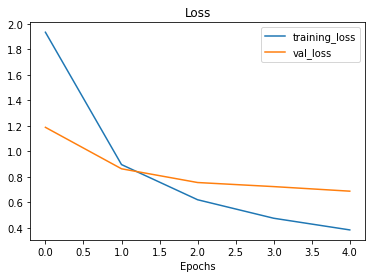

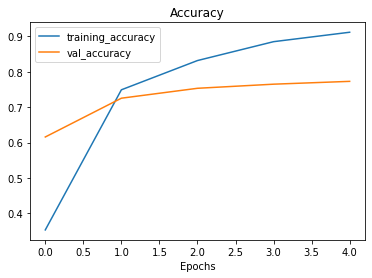

In [13]:
plot_loss_curves(resnet_history)

### Creating & testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [14]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

In [15]:
# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [16]:
# Fit the EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220711-121115
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8920 - accuracy: 0.3880 - val_loss: 1.3413 - val_accuracy: 0.7236
Epoch 2/5
24/24 [==============================] - 16s 671ms/step - loss: 1.0845 - accuracy: 0.7787 - val_loss: 0.8909 - val_accuracy: 0.8148
Epoch 3/5
24/24 [==============================] - 15s 634ms/step - loss: 0.7663 - accuracy: 0.8333 - val_loss: 0.7139 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 15s 640ms/step - loss: 0.6179 - accuracy: 0.8587 - val_loss: 0.6226 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 18s 788ms/step - loss: 0.5214 - accuracy: 0.8880 - val_loss: 0.5681 - val_accuracy: 0.8608


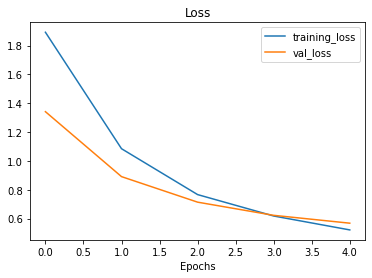

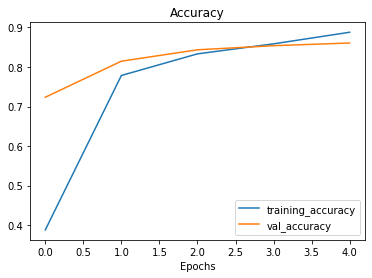

In [17]:
plot_loss_curves(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
# Number of layers in the efficientnetb0 feature extractor
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comparing our models' results using TensorBoard

In [24]:
# Upload TensorBoard dev records
!tensorboard dev upload \
  --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing 2 different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=BkORiCv2JjcS5RxusmfYMxgoBQUOmB&prompt=consent&access_type=off

In [25]:
!tensorboard dev list

https://tensorboard.dev/experiment/AdrnQPKMQKqlKg20D9J3DQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing 2 different TF Hub feature extraction model architectures using 10% of the training data
	Id                   AdrnQPKMQKqlKg20D9J3DQ
	Created              2022-07-11 12:15:55 (5 minutes ago)
	Updated              2022-07-11 12:15:57 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3140571
Total: 1 experiment(s)


In [26]:
# Delete an experiment
# !tensorboard dev delete --experiment_id <id-goes-here>